#Urban Systems Project: 
##Floor Space, Lot Density and Built Density in NYC

### • Introduction:

In this study we explore multiple variables to measure urban density of New York City. We use building data, tax lot data and census tract data to generate variables representing urban density. NYC publish datasets on building information, tax lot and census data, therefore the goal of this project is to explore available dataset, define variables and build model to capture urban density in NYC. Then we compare these variables against the distance from the center of the city, which we defined as the location of the Empire State Building in Manhattan. 

In [4]:
##Import moudules for Python.
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import scipy
from scipy import stats
%pylab inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
import statsmodels.formula.api as smf
import geopandas as gp
import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import random
import seaborn
from IPython.display import Image, display

Populating the interactive namespace from numpy and matplotlib


/Users/ericlaibuffalo/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


###• Data Sources:
There are three datasets we used for this study:


__1) PLUTO Data:__ 
####http://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page
New York City’s Primary Land User Tax Lot Output (PLUTO)is the dataset published by the Department of City Planning (DCP) with information on zoning, tax assessments and building features in five Boroughs. Especially unique to PLUTO is that it provides detailed information of each lot such as land use, zoning, lot area, building footprint, building height, number of units, built year, zip code and Borough-Block-Lot ID (BBL). PLUTO also contains geo- spatial data of each lot, which allows further geo-spatial analysis and visualization in Geography Information System (GIS) applications such as Arc GIS 10.3 or CartoDB.

__2) NYC Building Footprint Data:__ 
####https://data.cityofnewyork.us/Housing-Development/Building-Footprints/nqwf-w8eh
Building footprint data is a Shapefile of footprint outlines of buildings in New York City. It is a dataset published and maintained by Department of Building (DOB) for construction permit, building inspection and violations.

__3) NYC Census Tract Data:__ 
####http://www1.nyc.gov/site/planning/data-maps/open-data/districts-download-metadata.page
Census Tract data is a Shapefile published by DCP which includes all census tracts in five boroughs of NYC.

###• Data Cleanning and Munging:

In [6]:
#Read PLUTO data of NYC.
#http://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page
MN = pd.read_csv('/Users/ericlaibuffalo/CUSP/Data/PLUTO/nyc_pluto_15v1/Mn.csv')
BK = pd.read_csv('/Users/ericlaibuffalo/CUSP/Data/PLUTO/nyc_pluto_15v1/BK.csv')
BX = pd.read_csv('/Users/ericlaibuffalo/CUSP/Data/PLUTO/nyc_pluto_15v1/BX.csv')
QN = pd.read_csv('/Users/ericlaibuffalo/CUSP/Data/PLUTO/nyc_pluto_15v1/QN.csv')
SI = pd.read_csv('/Users/ericlaibuffalo/CUSP/Data/PLUTO/nyc_pluto_15v1/SI.csv')
PLUTO = pd.concat([MN,BK,BX,QN,SI],ignore_index=True)

#gp.read_file('/Users/ericlaibuffalo/CUSP/Data/PLUTO/mappluto_15v1/PLUTO_NYC_CT.shp') 

/Users/ericlaibuffalo/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (6,7,8,10,27,50,52,53,77,79) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)
/Users/ericlaibuffalo/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (6,7,10,11,50,52,53,77,79) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)
/Users/ericlaibuffalo/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (4,6,7,8,10,11,50,52,53,77,79) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [7]:
PLUTO.columns

Index([u'Borough', u'Block', u'Lot', u'CD', u'CT2010', u'CB2010',
       u'SchoolDist', u'Council', u'ZipCode', u'FireComp', u'PolicePrct',
       u'HealthArea', u'Address', u'ZoneDist1', u'ZoneDist2', u'ZoneDist3',
       u'ZoneDist4', u'Overlay1', u'Overlay2', u'SPDist1', u'SPDist2',
       u'LtdHeight', u'AllZoning1', u'AllZoning2', u'SplitZone', u'BldgClass',
       u'LandUse', u'Easements', u'OwnerType', u'OwnerName', u'LotArea',
       u'BldgArea', u'ComArea', u'ResArea', u'OfficeArea', u'RetailArea',
       u'GarageArea', u'StrgeArea', u'FactryArea', u'OtherArea', u'AreaSource',
       u'NumBldgs', u'NumFloors', u'UnitsRes', u'UnitsTotal', u'LotFront',
       u'LotDepth', u'BldgFront', u'BldgDepth', u'Ext', u'ProxCode',
       u'IrrLotCode', u'LotType', u'BsmtCode', u'AssessLand', u'AssessTot',
       u'ExemptLand', u'ExemptTot', u'YearBuilt', u'BuiltCode', u'YearAlter1',
       u'YearAlter2', u'HistDist', u'Landmark', u'BuiltFAR', u'ResidFAR',
       u'CommFAR', u'FacilFAR', u'

In [8]:
PLUTO = PLUTO[['BoroCode','Tract2010','Block','BBL','LotArea','AssessLand','BldgArea','AllZoning1','LandUse']]
PLUTO.dropna
len(PLUTO)

859464

In [9]:
#Now we generate Census Tract number 'BoroCT2010' by combining borocode and tract number.
PLUTO['BoroCT2010'] = PLUTO['BoroCode']*1000000 + PLUTO['Tract2010']*100
PLUTO[:2]

,BoroCode,Tract2010,Block,BBL,LotArea,AssessLand,BldgArea,AllZoning1,LandUse,BoroCT2010
0,1,5,1,1000010010,7736692,104445450,2725731,R3-2/GI,8,1000500
1,1,1,1,1000010101,541886,4225950,541886,R3-2,8,1000100


In [10]:
BBL_LOT = PLUTO[['BoroCT2010','Block','BBL','LotArea','BldgArea','AssessLand','AllZoning1','LandUse']]
BBL_LOT.BBL = BBL_LOT.BBL.map(str)
BBL_LOT.BBL  = BBL_LOT.BBL .str.split('.').str.get(0)
BBL_LOT[:2]

/Users/ericlaibuffalo/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:2177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,BoroCT2010,Block,BBL,LotArea,BldgArea,AssessLand,AllZoning1,LandUse
0,1000500,1,1000010010,7736692,2725731,104445450,R3-2/GI,8
1,1000100,1,1000010101,541886,541886,4225950,R3-2,8


In [11]:
#Read NYC building data from Department of Building (DOB).
#https://data.cityofnewyork.us/Housing-Development/Building-Footprints/nqwf-w8eh
NYC = gp.GeoDataFrame.from_file('/Users/ericlaibuffalo/CUSP/Data/building_footprints_shape_07-15-3/building_0715.shp')
len(NYC)

1082940

In [12]:
NYC.columns

Index([       u'BBL',        u'BIN', u'BUILT_CODE', u'CONSTRUCTI',
         u'DOITT_ID', u'FACILITY_T', u'FEATURE_CO', u'GROUND_ELE',
       u'HEIGHT_ROO', u'LAST_MODIF', u'LAST_STATU',       u'NAME',
       u'NUM_FLOORS', u'SUB_FEATUR', u'Shape_Area', u'Shape_Leng',
         u'geometry'],
      dtype='object')

In [13]:
NYC = NYC[NYC.CONSTRUCTI!= 0]
#NYC['GFA'] = NYC['NUM_FLOORS']*NYC['Shape_Area']

In [14]:
#Drop the columns that we are not using for this study.
BFP_BBL = NYC[['BBL','BIN','Shape_Area','HEIGHT_ROO']]
BFP_BBL.columns = ['BBL','BIN','FP_AREA','HEIGHT']
BFP_BBL.BBL = BFP_BBL.BBL.map(str)
BFP_BBL[:2]

,BBL,BIN,FP_AREA,HEIGHT
0,4155980564,4462384,1768.567205,26.528549
1,4163500400,4467306,1105.077843,17.947245


In [15]:
#There can be multiple buildings on one lot, therefore we sum up the building footprint area per lot.
BBL_FP = BFP_BBL.groupby('BBL')['FP_AREA'].sum()
BBL_FP.to_csv('BBL_FP.csv')
BBL_FP = pd.read_csv('BBL_FP.csv', names = ['BBL','FP'])
BBL_FP.BBL = BBL_FP.BBL.map(str)
BBL_FP[:2]

,BBL,FP
0,1000010010,947928.212971
1,1000010101,104322.587485


In [16]:
#Merge building footprint data and PLUTO lot data, to have a dataset that aggregates all building area and 
#lot information by BBL.
LOT_FP = pd.merge(BBL_LOT,BBL_FP, on='BBL',how = 'inner')
LOT_FP.columns = ['BoroCT2010','Block','BBL','LotArea','FloorSpace','AssessLand','Zoning','LandUse','FootPrint']
LOT_FP.head()

,BoroCT2010,Block,BBL,LotArea,FloorSpace,AssessLand,Zoning,LandUse,FootPrint
0,1000500,1,1000010010,7736692,2725731,104445450,R3-2/GI,8,947928.212971
1,1000100,1,1000010101,541886,541886,4225950,R3-2,8,104322.587485
2,1000100,1,1000010201,2764190,603130,14972400,R3-2,,325430.120315
3,1000900,2,1000020001,209215,280000,18818100,M1-4/LM,7,105381.701407
4,1000900,2,1000020002,191502,158197,18787500,C4-6/LM,7,56371.970884


In [17]:
LOT_FP_CT = LOT_FP.groupby('BoroCT2010')[['LotArea','FootPrint','FloorSpace','AssessLand']].sum()
LOT_FP_CT.to_csv('LOT_FP_CT.csv')
LOT_FP_CT = pd.read_csv('LOT_FP_CT.csv')
LOT_FP_CT.BoroCT2010 = LOT_FP_CT.BoroCT2010.map(str)
LOT_FP_CT.BoroCT2010 = LOT_FP_CT.BoroCT2010.str.split('.').str.get(0)

LOT_FP_CT[:2]

,BoroCT2010,LotArea,FootPrint,FloorSpace,AssessLand
0,1000000,3029425,277196.189682,478815,63316800
1,1000100,3306076,429752.707800,1145016,19198350


In [18]:
#Read Census Tract Data from NYC Department of City Planning:
#http://www1.nyc.gov/site/planning/data-maps/open-data/districts-download-metadata.page

CT = gp.GeoDataFrame.from_file('/Users/ericlaibuffalo/CUSP/Data/NYC Data/nyct2010_16a/nyct2010.shp') 
CT = CT[['BoroCT2010','Shape_Area']]
CT.columns = ['BoroCT2010','CT_Land']
CT = CT.groupby('BoroCT2010')['CT_Land'].sum()
CT.to_csv('CT.csv')
CT = pd.read_csv('CT.csv', names = ['BoroCT2010','CT_Land'])
CT.BoroCT2010 = CT.BoroCT2010.map(str)

CT[:2]

,BoroCT2010,CT_Land
0,1000100,1844421.238370
1,1000201,971628.184379


In [19]:
LOT_FP_LAND = pd.merge(LOT_FP_CT,CT, on='BoroCT2010',how = 'inner')
LOT_FP_LAND.columns = ['BoroCT2010','LotArea','FootPrint','FloorSpace','AssessLand','SurfaceArea']
LOT_FP_LAND[:2]

,BoroCT2010,LotArea,FootPrint,FloorSpace,AssessLand,SurfaceArea
0,1000100,3306076,429752.707800,1145016,19198350,1844421.23837
1,1000500,7736692,947928.212971,2725731,104445450,9081808.05089


In [20]:
LOT_FP_LAND['land-lot'] = LOT_FP_LAND.SurfaceArea-LOT_FP_LAND.LotArea
LOT_FP_LAND['lot-fp'] = LOT_FP_LAND.LotArea-LOT_FP_LAND.FootPrint

LOT_FP_LAND = LOT_FP_LAND[LOT_FP_LAND['land-lot']>=0]
LOT_FP_LAND = LOT_FP_LAND[LOT_FP_LAND['lot-fp']>=0]

len(LOT_FP_LAND)

1730

###Methodology:
####Calculate parameters for urban density
In order to measure density of NYC in multiple ways, we defined different parameters by computing across different datasets. There are some current defined parameters such as Floor Area Ratio (FAR), however we wonder if there can be other variables to measure building density and urban land utilization. 

Thereore we define following parameters (figure below): 

                             s = floorSpace density

                             p = footPrint density

                             f = Floor area ratio

                             l = Lot density

                             r = Footprint-Lot ratio



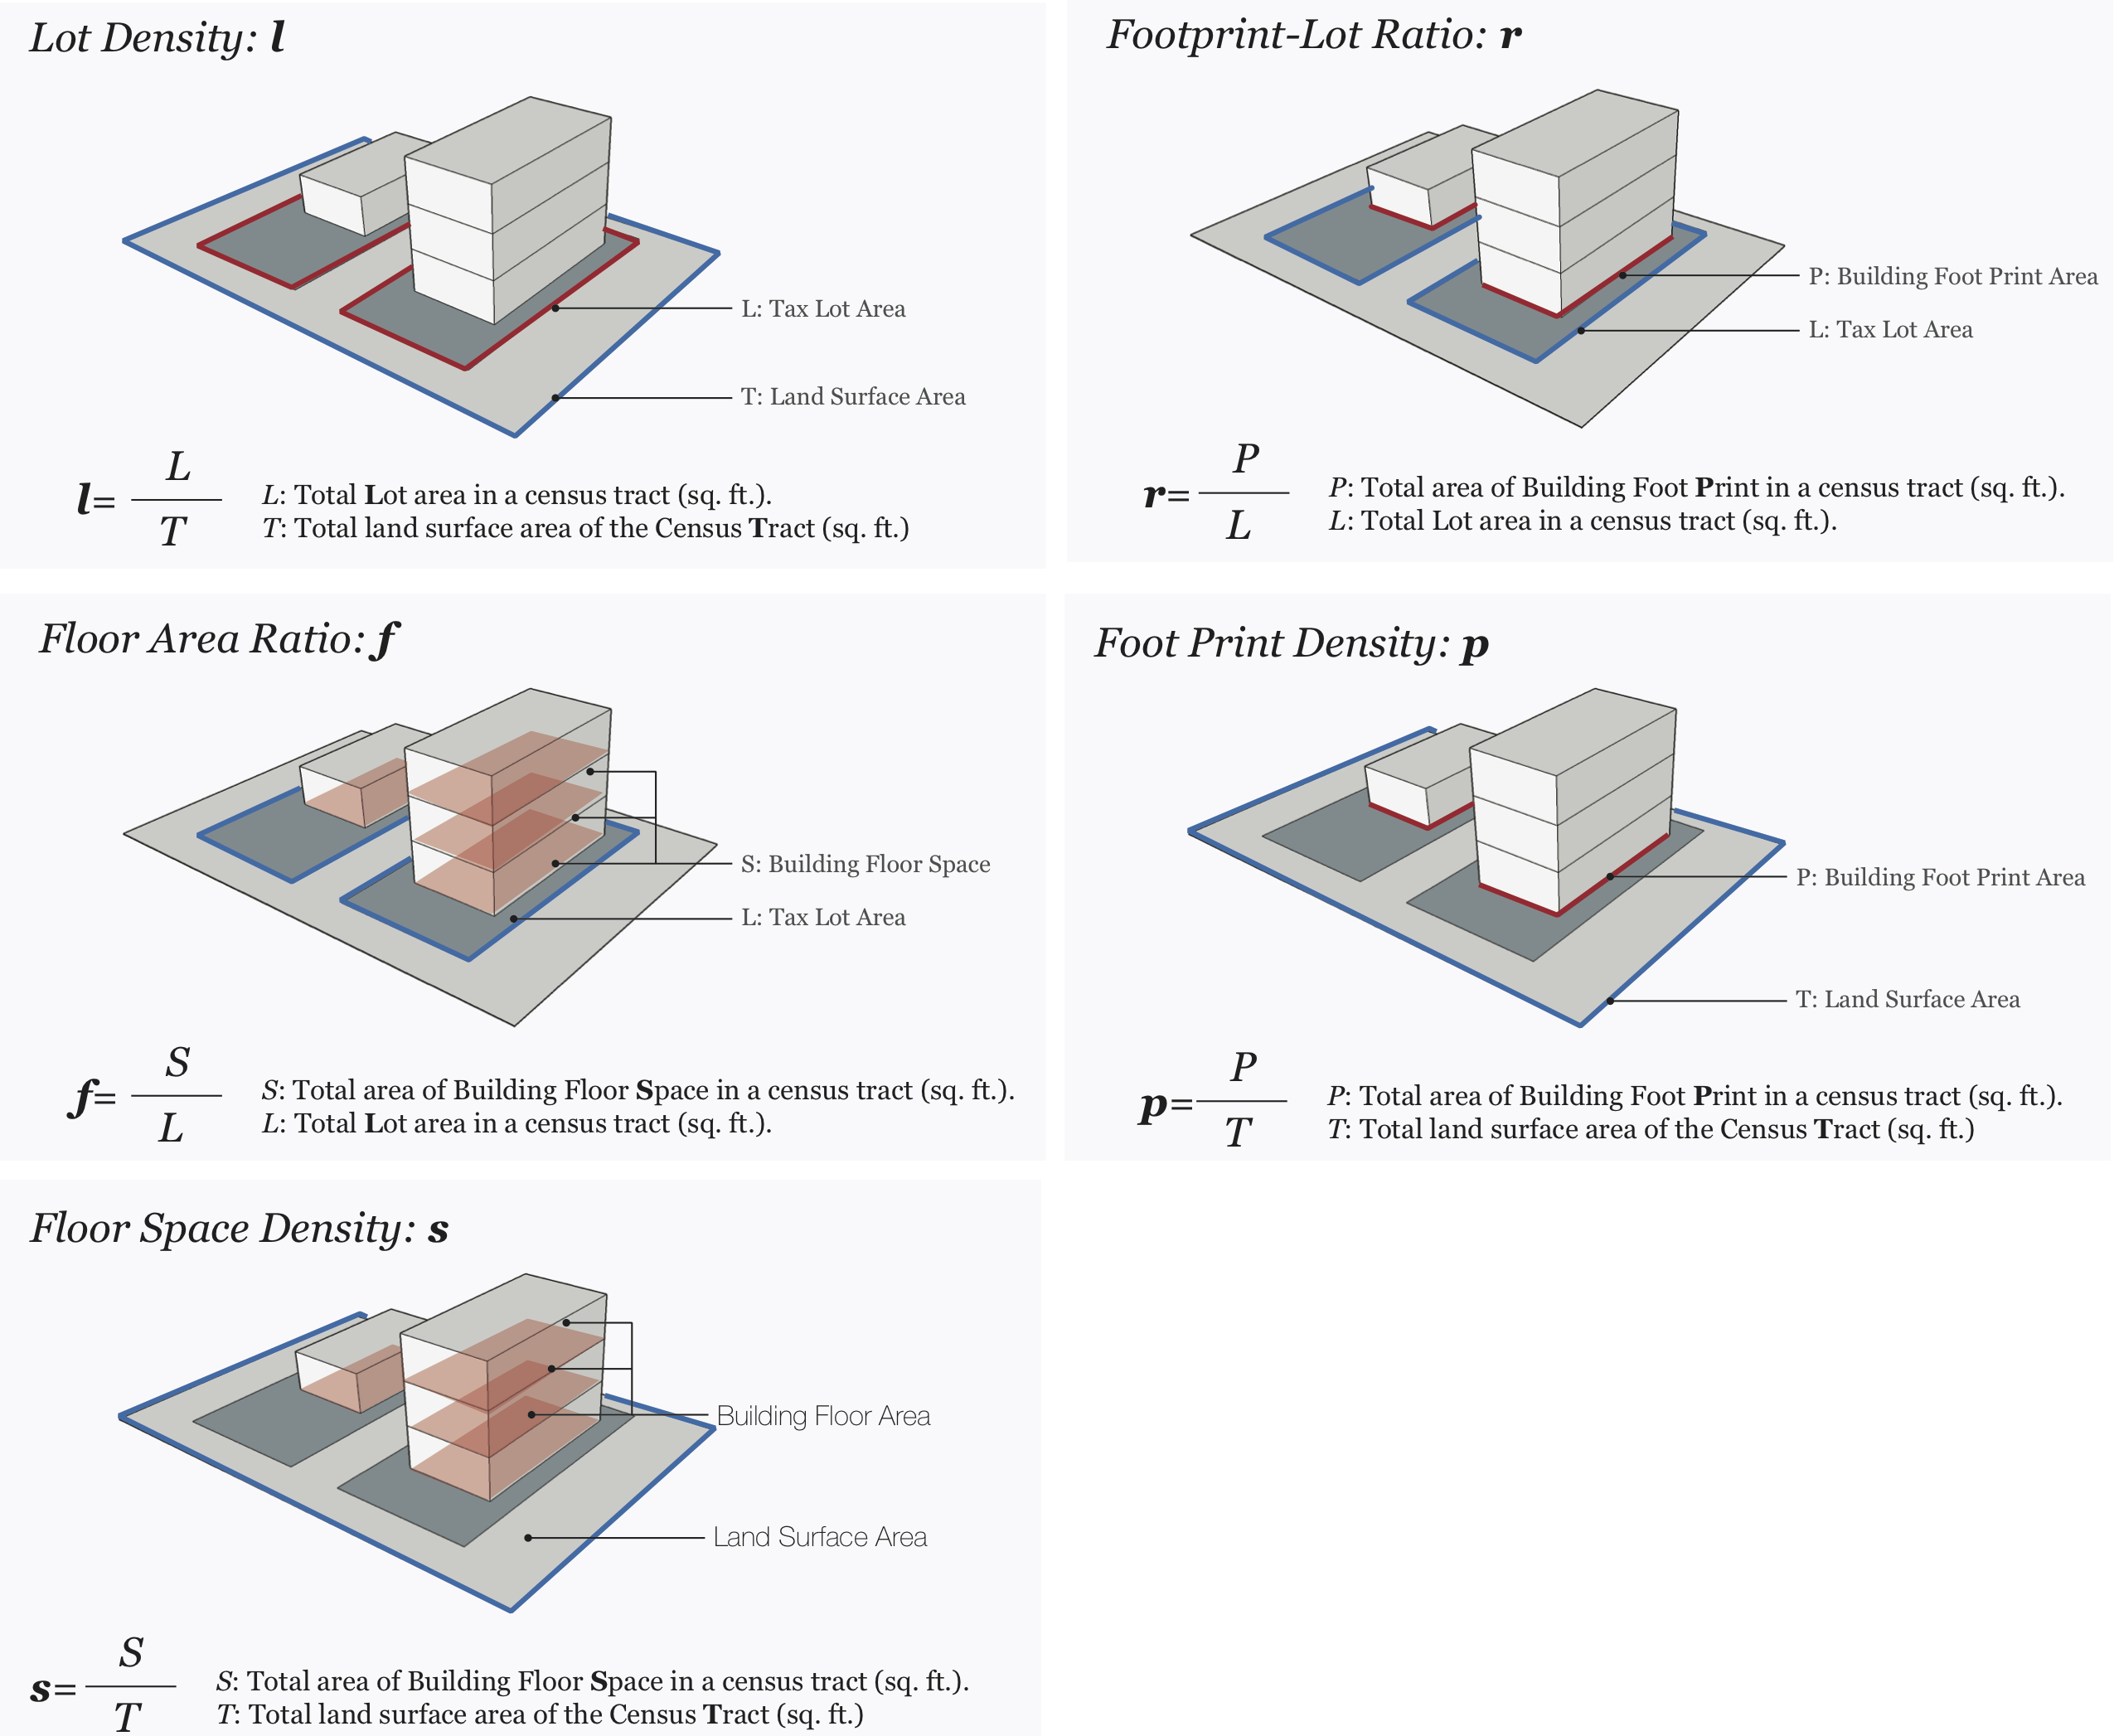

In [21]:
display(Image(filename='/Users/ericlaibuffalo/CUSP/Urban Systems/Project/Building-Density.png')) 

In [22]:
#Generate these parameter by calculating variables in dataset.
LOT_FP_LAND['l'] = (LOT_FP_LAND.LotArea/LOT_FP_LAND.SurfaceArea).round(decimals=4)
LOT_FP_LAND['r'] = (LOT_FP_LAND.FootPrint/LOT_FP_LAND.LotArea).round(decimals=4)
LOT_FP_LAND['f'] = (LOT_FP_LAND.FloorSpace/LOT_FP_LAND.FootPrint).round(decimals=4)
LOT_FP_LAND['p'] = (LOT_FP_LAND.FootPrint/LOT_FP_LAND.SurfaceArea).round(decimals=4)
LOT_FP_LAND['s'] = (LOT_FP_LAND.FloorSpace/LOT_FP_LAND.SurfaceArea).round(decimals=4)

In [23]:
#Print the head of the dataset.
LOT_FP_LAND.head()

,BoroCT2010,LotArea,FootPrint,FloorSpace,AssessLand,SurfaceArea,land-lot,lot-fp,l,r,f,p,s
1,1000500,7736692,947928.212971,2725731,104445450,9081808.05089,1345116.05089,6788763.787029,0.8519,0.1225,2.8755,0.1044,0.3001
2,1000600,1349249,571785.226553,4715391,72211614,2583417.58197,1234168.58197,777463.773447,0.5223,0.4238,8.2468,0.2213,1.8253
3,1000700,1637098,1159209.752420,26876019,717689047,2528569.60166,891471.60166,477888.247580,0.6474,0.7081,23.1848,0.4584,10.6289
4,1000800,1008614,687704.005003,4010277,67086995,2366871.16185,1358257.16185,320909.994997,0.4261,0.6818,5.8314,0.2906,1.6943
5,1000900,1692004,1204466.234560,22536759,579955700,3122058.76235,1430054.76235,487537.765440,0.5420,0.7119,18.7110,0.3858,7.2186


In [24]:
#Calculate the average Floor Area Ratio (FAR) of NYC.
LOT_FP_LAND['FloorSpace'].sum()/LOT_FP_LAND['FootPrint'].sum()

3.137381084915628

###• Density by Census Tract vs. Distance from the Center of NYC:

In [25]:
Dist = pd.read_csv('/Users/ericlaibuffalo/CUSP/MyStudy/Space-Value/Data/cartodb-query.csv')
Dist = Dist [['boroct2010','boroname','ct_density','dist_from_esb','shape_area','floorarea_sqft']]
Dist.columns = ['BoroCT2010','boroname','ct_density','dist_from_esb','shape_area','floorarea_sqft']
Dist['BoroCT2010'] = Dist['BoroCT2010'].astype(str)
Dist[:2]

,BoroCT2010,boroname,ct_density,dist_from_esb,shape_area,floorarea_sqft
0,1000100,Manhattan,0.62080,6983.695477,1844421.238370,1145016
1,1000201,Manhattan,1.64013,3768.858540,971628.184379,1593597


In [26]:
final_data = pd.merge(LOT_FP_LAND,Dist, on = 'BoroCT2010', how='inner')
final_data = final_data[['BoroCT2010','boroname','LotArea','FootPrint','FloorSpace','SurfaceArea',
                         'ct_density','dist_from_esb','floorarea_sqft','s','p','f','l','r']]
final_data.head()

,BoroCT2010,boroname,LotArea,FootPrint,FloorSpace,SurfaceArea,ct_density,dist_from_esb,floorarea_sqft,s,p,f,l,r
0,1000500,Manhattan,7736692,947928.212971,2725731,9081808.05089,0.300131,6218.908678,2725731,0.3001,0.1044,2.8755,0.8519,0.1225
1,1000600,Manhattan,1349249,571785.226553,4715391,2583417.58197,1.865370,3782.728645,4819029,1.8253,0.2213,8.2468,0.5223,0.4238
2,1000700,Manhattan,1637098,1159209.752420,26876019,2528569.60166,11.133145,4837.180732,28150931,10.6289,0.4584,23.1848,0.6474,0.7081
3,1000800,Manhattan,1008614,687704.005003,4010277,2366871.16185,1.708594,3821.209707,4044021,1.6943,0.2906,5.8314,0.4261,0.6818
4,1000900,Manhattan,1692004,1204466.234560,22536759,3122058.76235,7.227931,5142.411437,22566025,7.2186,0.3858,18.7110,0.5420,0.7119


In [27]:
#We can export this dataset for more statistical analysis in Stata.
final_data.to_csv('Final_Dataset.csv')

###Map Visualization:
Now we can visualize these variables by census tract on maps. We use CartoDB as the tool to visualize data.
####New York City by Census Tracts:

In [50]:
#Now visualize all census tracts in NYC for multiple variables. 
from IPython.display import HTML
HTML('<iframe width="100%" height="520" frameborder="0" src="https://nyu.cartodb.com/u/yuan/viz/aa14b992-148a-11e6-b9f0-0ecd1babdde5/embed_map" allowfullscreen webkitallowfullscreen mozallowfullscreen oallowfullscreen msallowfullscreen></iframe>')

We can also start looking into a finer granularity in Manhattan, to compare multiple variables we created.
####Manhattan by Census Tract, with tax lot and building footprint:

In [51]:
#Plot Census Tract, tax lot and building footprint data on CartoDB for Manhattan.
HTML('<iframe width="100%" height="520" frameborder="0" src="https://nyu.cartodb.com/u/yuan/viz/24225582-145e-11e6-8669-0ecd1babdde5/embed_map" allowfullscreen webkitallowfullscreen mozallowfullscreen oallowfullscreen msallowfullscreen></iframe>')

####Brooklyn by Census Tract, with tax lot and building footprint:

In [52]:
#Plot Census Tract, tax lot and building footprint data on CartoDB for Brooklyn.
HTML('<iframe width="100%" height="520" frameborder="0" src="https://nyu.cartodb.com/u/yuan/viz/46832ffa-14ce-11e6-a2e5-0e3ff518bd15/embed_map" allowfullscreen webkitallowfullscreen mozallowfullscreen oallowfullscreen msallowfullscreen></iframe>')

Now we will plot data to visualize how different density parameters change with the distance from the center of the city as we defined. 

In [31]:
#Now let's read Census Tract file.
CT = gp.GeoDataFrame.from_file('/Users/ericlaibuffalo/CUSP/Data/NYC Data/nyct2010_16a/nyct2010.shp') 
CT = CT[['BoroCT2010','geometry']]
CT['BoroCT2010'] = CT['BoroCT2010'].map(lambda x: x.encode('ascii','ignore'))
geo_data = gp.GeoDataFrame(pd.merge(final_data, CT,on = 'BoroCT2010'))
type(geo_data)

geopandas.geodataframe.GeoDataFrame

In [32]:
#geo_data['geometry'] = geo_data['geometry_y']
#del geo_data['geometry_y']
#del geo_data['geometry_x']

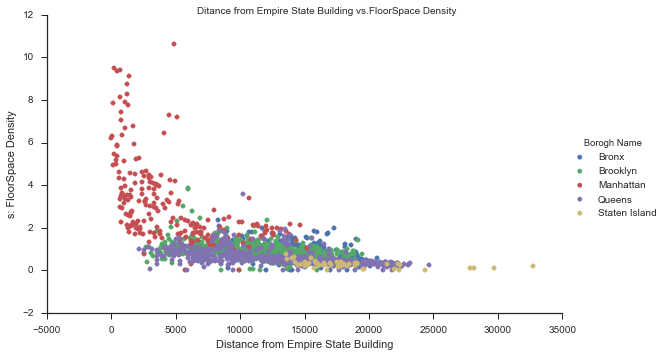

In [39]:
seaborn.set(style='ticks')
boro = np.unique(final_data.boroname).tolist()
ax1 = seaborn.FacetGrid(data=final_data, hue='boroname', hue_order=boro, aspect=1.61,size=5)
ax1.map(plt.scatter,'dist_from_esb','s').add_legend(title = 'Borogh Name').set_axis_labels("Distance from Empire State Building", "s: FloorSpace Density")
ax1.fig.suptitle('Ditance from Empire State Building vs.FloorSpace Density') 

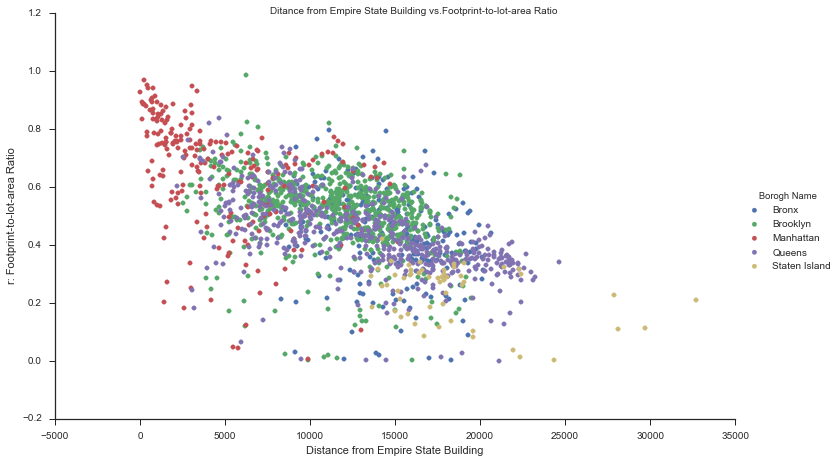

In [40]:
seaborn.set(style='ticks')
boro = np.unique(final_data.boroname).tolist()
fg = seaborn.FacetGrid(data=final_data, hue='boroname', hue_order=boro, aspect=1.61,size=6.5)
fg.map(plt.scatter,'dist_from_esb','r').add_legend(title = 'Borogh Name').set_axis_labels("Distance from Empire State Building", "r: Footprint-to-lot-area Ratio")
fg.fig.suptitle('Ditance from Empire State Building vs.Footprint-to-lot-area Ratio') 


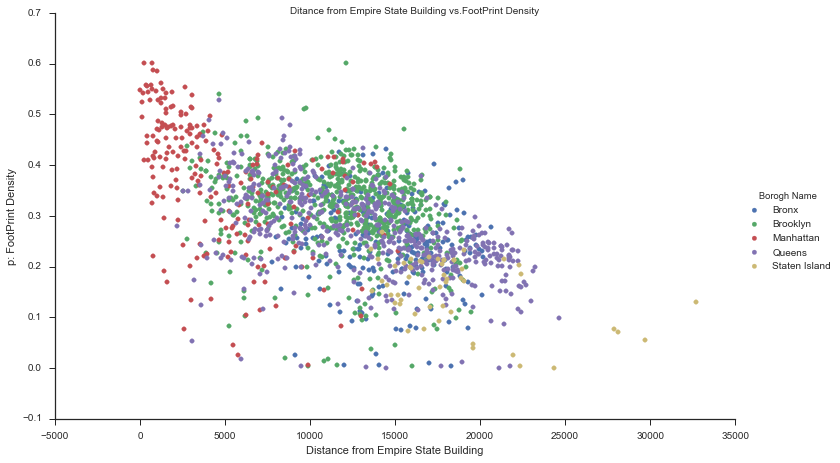

In [42]:
seaborn.set(style='ticks')
boro = np.unique(final_data.boroname).tolist()
fg = seaborn.FacetGrid(data=final_data, hue='boroname', hue_order=boro, aspect=1.61,size=6.5)
fg.map(plt.scatter,'dist_from_esb','p').add_legend(title = 'Borogh Name').set_axis_labels("Distance from Empire State Building", "p: FootPrint Density")
fg.fig.suptitle('Ditance from Empire State Building vs.FootPrint Density') 

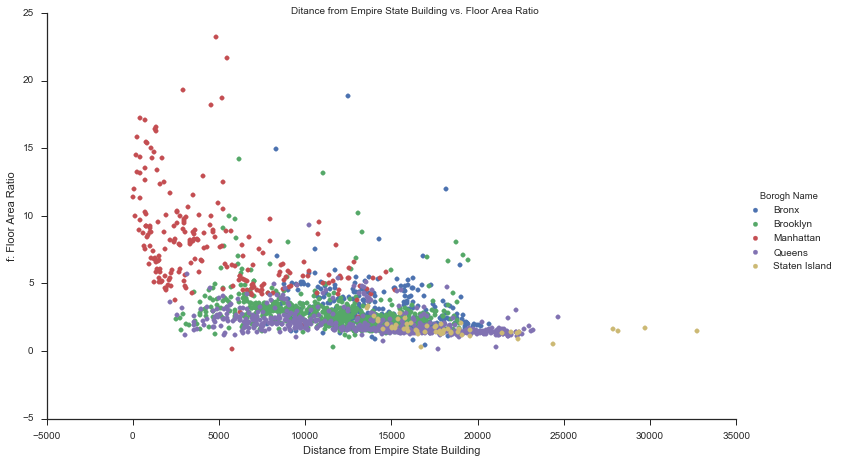

In [43]:
seaborn.set(style='ticks')
boro = np.unique(final_data.boroname).tolist()
fg = seaborn.FacetGrid(data=final_data, hue='boroname', hue_order=boro, aspect=1.61,size=6.5)
fg.map(plt.scatter,'dist_from_esb','f').add_legend(title = 'Borogh Name').set_axis_labels("Distance from Empire State Building", "f: Floor Area Ratio")
fg.fig.suptitle('Ditance from Empire State Building vs. Floor Area Ratio') 

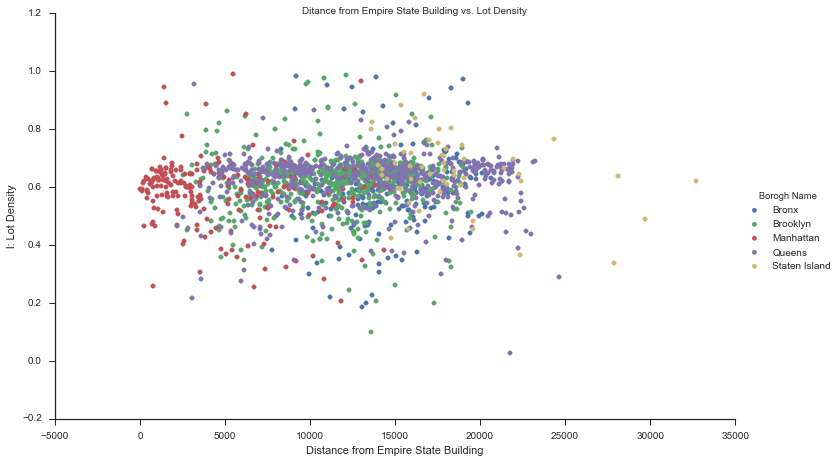

In [44]:
import seaborn

seaborn.set(style='ticks')
boro = np.unique(final_data.boroname).tolist()
fg = seaborn.FacetGrid(data=final_data, hue='boroname', hue_order=boro, aspect=1.61,size=6.5)
fg.map(plt.scatter,'dist_from_esb','l').add_legend(title = 'Borogh Name').set_axis_labels("Distance from Empire State Building", "l: Lot Density")
fg.fig.suptitle('Ditance from Empire State Building vs. Lot Density') 

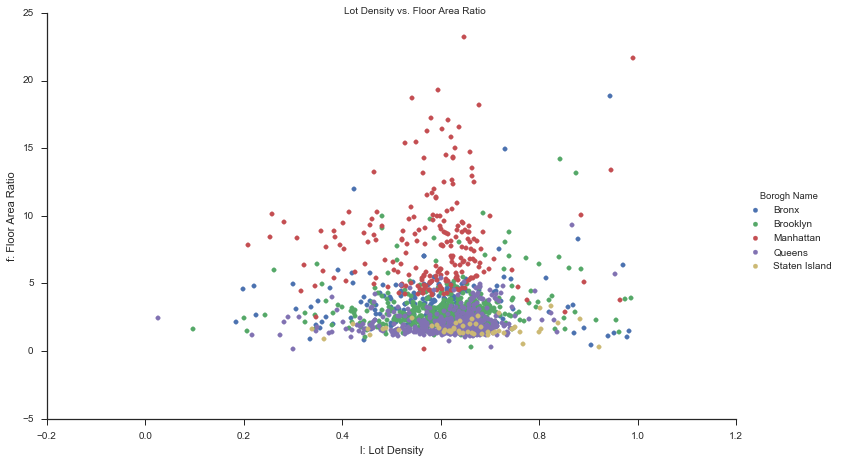

In [38]:
seaborn.set(style='ticks')
boro = np.unique(final_data.boroname).tolist()
fg = seaborn.FacetGrid(data=final_data, hue='boroname', hue_order=boro, aspect=1.61,size=6.5)
fg.map(plt.scatter,'l','f').add_legend(title = 'Borogh Name').set_axis_labels("l: Lot Density", "f: Floor Area Ratio")
fg.fig.suptitle('Lot Density vs. Floor Area Ratio') 

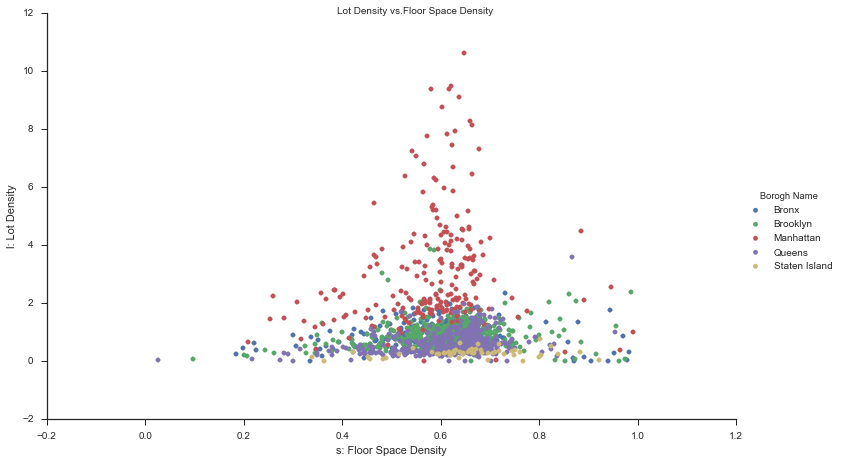

In [45]:
seaborn.set(style='ticks')
boro = np.unique(final_data.boroname).tolist()
fg = seaborn.FacetGrid(data=final_data, hue='boroname', hue_order=boro, aspect=1.61,size=6.5)
fg.map(plt.scatter,'l','s').add_legend(title = 'Borogh Name').set_axis_labels("s: Floor Space Density", "l: Lot Density")
fg.fig.suptitle('Lot Density vs.Floor Space Density') 

###• Regression Analysis:

In [112]:
# Let's examine the correlation matrix.
print final_data[['s','p','f','l','r','dist_from_esb']].corr()

                      s         p         f         l         r  dist_from_esb
s              1.000000  0.592229  0.872480 -0.002359  0.595979      -0.595717
p              0.592229  1.000000  0.297249  0.149229  0.889230      -0.533785
f              0.872480  0.297249  1.000000 -0.040229  0.349818      -0.552226
l             -0.002359  0.149229 -0.040229  1.000000 -0.268504       0.066436
r              0.595979  0.889230  0.349818 -0.268504  1.000000      -0.581774
dist_from_esb -0.595717 -0.533785 -0.552226  0.066436 -0.581774       1.000000


In [115]:
# Let's fit the logit.
mod = smf.ols(formula='dist_from_esb ~ s + p + f + l + r', data = final_data ).fit()
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:          dist_from_esb   R-squared:                       0.487
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     326.7
Date:                Sat, 07 May 2016   Prob (F-statistic):          1.80e-246
Time:                        12:46:19   Log-Likelihood:                -16656.
No. Observations:                1730   AIC:                         3.332e+04
Df Residuals:                    1724   BIC:                         3.336e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   2.655e+04   1301.114     20.405      0.0

In [116]:
LOT_FP_LAND['pred'] = mod.predict()

In [117]:
LOT_FP_LAND['diff'] = (LOT_FP_LAND.pred/LOT_FP_LAND.AssessLand)
LOT_FP_LAND['diff'].describe()

count    1730.000000
mean        0.001261
std         0.000957
min        -0.000016
25%         0.000618
50%         0.001099
75%         0.001705
max         0.009277
Name: diff, dtype: float64